## Redshift example
This notebook demonstrates building a normalizing flow with `pzflow` to learn the joint probability distribution of galaxy magnitudes and redshifts.

You do not need to have any previous knowledge of normalizing flows to get started with `pzflow`, however if you are interested, here are some good sources:
- Eric Jang's tutorial: [part 1](https://blog.evjang.com/2018/01/nf1.html), [part 2](https://blog.evjang.com/2018/01/nf2.html)
- [Here](https://github.com/janosh/awesome-normalizing-flows)  is a comprehensive list of papers, blogs, videos, and packages
- Two good intro papers using Coupling Layers: [NICE](http://arxiv.org/abs/1605.08803), [Real NVP](http://arxiv.org/abs/1605.08803)
- The paper on [Neural Spline Couplings](https://arxiv.org/abs/1906.04032)

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import corner

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, RollingSplineCoupling, ColorTransform
from pzflow.examples import galaxy_data

***Jax GPU Note:*** The default version of Jax that you get when you do `pip install pzflow` is not GPU enabled. If you want to run `pzflow` on a GPU, you need to install the GPU enabled Jax following the instructions [here](https://github.com/google/jax). Note that you may also need to add the following to your `.bashrc`:
```
# cuda setup
export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
export PATH=$PATH:/usr/local/cuda/bin
```
If you have installed the GPU enabled Jax, but want to run on a CPU instead, uncomment the cell below

In [2]:
# Global flag to set a specific platform, must be used at startup.
# import jax
# jax.config.update('jax_platform_name', 'cpu')

First let's load the example galaxy data set included with `pzflow`.

In [3]:
data = galaxy_data()
data.head()

,redshift,u,g,r,i,z,y
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


You can see the first column is redshift, and the subsequent columns are galaxy magnitudes in the 6 LSST bandpass filters. The data is in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

Now we will build a normalizing flow to model this data. We will construct a bijector made of two parts:

**1. Rolling Spline Coupling** --  
This is a bijector I created that alternates Neural Spline Couplings and "Rolling" layers.
This is the bijector I would recommend using "out of the box".
It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network

Only `nlayers` is required.
For this example, we will set `nlayers` = 7 to match the input dimension, and we will leave everything else to their default values.
Feel free to play around with changing the other parameters.


**2. Color Transform** --  
This is a bijector that performs the following transformation:  
$(\theta, \, R, \, u\!-\!g, \, g\!-\!r, \, r\!-\!i, \, i\!-\!z, \, z\!-\!y) \to  (\text{redshift}, \, u, \, g, \, r, \, i, \, z, \, y)$  
where
$\text{redshift} = \mathrm{softplus}(\theta)$
and
$r = R \cdot \sigma_r + \bar{r}$.  
Placing this Color Transform very last in our chain of bijectors means that the normalizing flow is optimizing the Neural Spline parameters to map the Gaussian samples onto the galaxy colors, rather than the galaxy magnitudes.
This is useful, as redshift correlates more directly with galaxy colors.
The value $R$ is just a normalized version of the $r$ band magnitude, which serves as a proxy for overall galaxy luminosity.
In addition, the transformation $\text{redshift} = \mathrm{softplus}(\theta)$ ensures that the sampled redshifts are always positive.

We construct the total bijector by chaining these two bijectors together.

After constructing the bijector, we create the flow by instantiating a `Flow` object.
We have to give it the bijector we just created, as well as the names of the columns in our data set.

In [4]:
# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# set the Color Transform parameters to use the
# r band as the reference magnitude
ref_band = "r"
ref_idx = data.columns.get_loc(ref_band)
ref_mean = data[ref_band].mean()
ref_stdd = data[ref_band].std()

# construct our bijector out of
# 1. a Rolling Spline Coupling
# 2. a Color Transform
bijector = Chain(
    RollingSplineCoupling(nlayers),
    ColorTransform(ref_idx, ref_mean, ref_stdd)
)

# create the normalizing flow. We have to give it
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(data.columns, bijector)

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the documentation for the normalizing flow for more details.
For this example, we will use the defaults (except we will set `verbose=True` so that training losses are printed throughout the training process.)

*Warning:* this takes about 8 minutes to run on my CPU. (but only 1 minute on a GPU!)

In [5]:
%%time
losses = flow.train(data, epochs=25, batch_size=1024, verbose=True)

9.5054
-0.4169
-1.9885
-2.7056
-3.1896
-3.5314
-3.7045
-3.7302
-4.0969
-4.2526
-4.2900
-4.2942
-4.2962
-4.6360
-4.7311
-4.3207
-4.7741
-4.7014
-4.7973
-4.8681
-4.7970
-5.0534
-5.0341
-5.1387
-5.1162
-5.2642
CPU times: user 31min 48s, sys: 1h 36min 1s, total: 2h 7min 49s
Wall time: 8min 25s


Now let's plot the training losses to make sure everything looks like we expect it to...

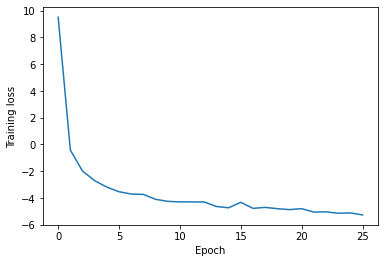

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make a corner plot, comparing these samples to the training set.

In [7]:
samples = flow.sample(10000, seed=0)

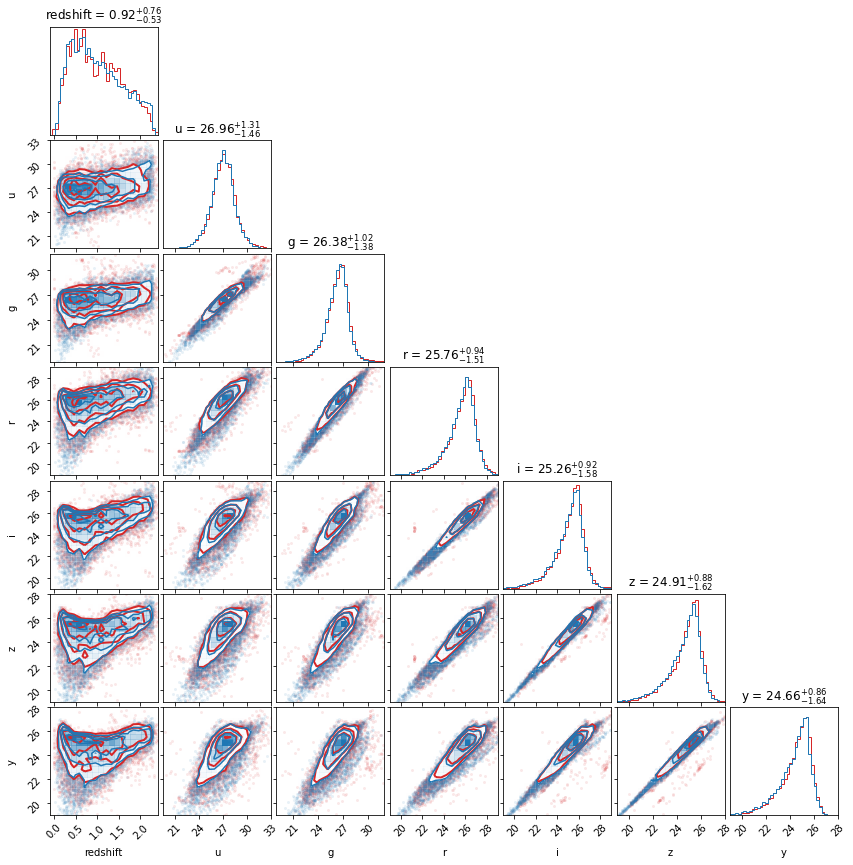

In [8]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

Looks great!

We can also use the flow to calculate posteriors for galaxies using the `posterior` method.
We can pass `column` and `grid` to calculate posteriors for different quanities.

For example, let's calculate redshift posteriors for the first 3 galaxies, using the default grid:

In [9]:
grid = np.arange(0, 2.02, 0.02)
pdfs = flow.posterior(data.iloc[:3], column="redshift", grid=grid)

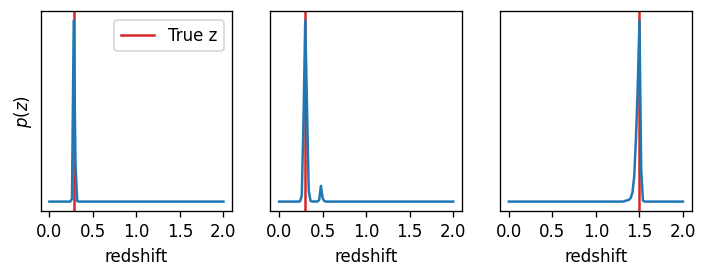

In [10]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

for i,ax in enumerate(axes):
    true_z = data.iloc[i]['redshift']
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(grid, pdfs[i])
    ax.set(xlabel="redshift",
           xticks=[0,0.5,1,1.5,2],
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(z)$')
plt.show()

We can also draw posteriors for magnitudes. For example, lets draw posteriors for the $u$ band:

In [11]:
u_grid = np.arange(21, 30, 0.1)
u_pdfs = flow.posterior(data.iloc[:3], column='u', grid=u_grid)

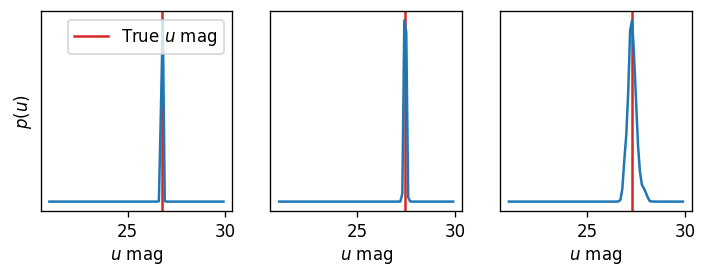

In [12]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

grid = np.arange(0, 2.02, 0.02)
for i,ax in enumerate(axes):
    true_u = data.iloc[i]['u']
    ax.axvline(true_u, 0, 1, c="C3",
               label='True $u$ mag')
    ax.plot(u_grid, u_pdfs[i])
    ax.set(xlabel="$u$ mag", 
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(u)$')
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [13]:
flow.info = f"""
This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import galaxy_data
>>> data = galaxy_data()

This flow was created with pzflow version {pzflow.__version__}
"""

In [14]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import galaxy_data
>>> data = galaxy_data()

This flow was created with pzflow version 0.0.1



Now let's save the flow to a file that can be loaded later:

In [15]:
flow.save("example-flow.dill")

This file can be loaded on Flow instantiation:

In [16]:
flow = Flow(file="example-flow.dill")

This example flow is also packaged with `pzflow`, so you can load it and play with it whenever you want:

In [17]:
from pzflow.examples import example_flow
flow = example_flow()

See! It's the same one:

In [18]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import galaxy_data
>>> data = galaxy_data()

This flow was created with pzflow version 0.0.1

